# Initialization

In [9]:
import os
import torch, pyro, numpy as np 

from clipppy.globals import register_globals
from clipppy import load_config
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5))

torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

register_globals(**globals()) # clipppy magic

In [10]:
# from plotting import plot_mult, test_import, test_import2
# import collections
# test_import(1)

def plot_mult(plots, nrows = 1, colorbar = False, size_x = 16, size_y = 8, cmap = [None]):
    """
    plots: list of what should be platted
    nrows: number of rows
    colobar: if True, a colorbar on each plot is plotted
    size_x, size_y: figsize = (size_x, size_y)
    """
    
    ncols = len(plots) // nrows
    N = len(plots)
    if len(cmap): cmap = cmap*N

    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x, size_y))
    for ax, plot, i in zip(axes.flatten(), plots, range(N)):
        im = ax.imshow(plot, cmap = cmap[i])
        if colorbar == True:
            fig.colorbar(im, fraction=0.046, pad=0.04, ax = ax)
    plt.show()

### Load config

In [11]:
SYSTEM_NAME = "ngc4414"

os.makedirs(SYSTEM_NAME, exist_ok=True)
BASEDIR = os.path.join(SYSTEM_NAME) # only used for saving
os.makedirs(BASEDIR, exist_ok=True) # only used for saving

In [12]:
SOURCE_DIR = '../../mock_data/sources'
source_name = f'{SYSTEM_NAME}.npy'

config = load_config('lens_config_gen_mock.yaml', base_dir=SOURCE_DIR,
                     source_name=source_name) # clipppy magic

# model = config.umodel # clippppy magic
# guide = config.guide  # should play around with it

# MASK = config.kwargs['defs']['mask']          # clipppy magic
# NOISE = model.stochastic_specs['sigma_stat']  # noise is a spec of the stochastic process; clipppy magic
# PARAMS = YAML().load(open('params.yaml'))[SYSTEM_NAME] # Real paramaters of system

In [19]:
X, Y = config.kwargs['defs']['XY']

In [36]:
np.array(X)

array([[-2.49375, -2.48125, -2.46875, ...,  2.46875,  2.48125,  2.49375],
       [-2.49375, -2.48125, -2.46875, ...,  2.46875,  2.48125,  2.49375],
       [-2.49375, -2.48125, -2.46875, ...,  2.46875,  2.48125,  2.49375],
       ...,
       [-2.49375, -2.48125, -2.46875, ...,  2.46875,  2.48125,  2.49375],
       [-2.49375, -2.48125, -2.46875, ...,  2.46875,  2.48125,  2.49375],
       [-2.49375, -2.48125, -2.46875, ...,  2.46875,  2.48125,  2.49375]],
      dtype=float32)

In [37]:
config.umodel.alphas['main'].flux(np.array(X), np.array(Y))

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [ ]:
model(X = X, Y = Y)

In [26]:
# Only if we have the test 'config_gen_mock_test.yaml'
try:
    PARAMS['truth'] = collections.OrderedDict(config.kwargs['params']['truth'])
    print('Set other true params!')
except:
    pass

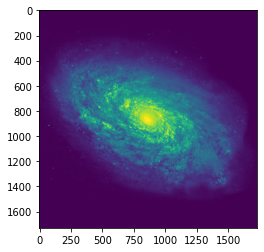

tensor(True)
1
ordereddict([('scale', 1.0), ('truth', ordereddict([('ext/gamma_1', 0.007), ('ext/gamma_2', 0.01), ('main/x', 0.3), ('main/y', 0.1), ('main/phi', 0.0), ('main/q', 1.0), ('main/index', 1.0), ('main/r_e', 1.0), ('main/I_e', 5.0)])), ('init', ordereddict([('ext/gamma_1', 0.0), ('ext/gamma_2', 0.0), ('main/phi', 0.5), ('main/q', 0.5), ('main/r_ein', 1.42), ('main/slope', 2.0), ('main/x', 0.0), ('main/y', 0.0), ('lenslight/x', 0.0), ('lenslight/y', 0.0), ('lenslight/phi', 0.0), ('lenslight/q', 1.0), ('lenslight/index', 1.0), ('lenslight/r_e', 1.0), ('lenslight/I_e', 5.0)]))])


In [28]:
plt.imshow(np.load(f'{SOURCE_DIR}/{source_name}'))
plt.show()

for i in [MASK, NOISE, PARAMS]:
    print(i)

# Generate mock data

#### Utilities

In [29]:
from skimage.transform import downscale_local_mean
from scipy.ndimage import filters
from pyrofit.lensing.utils import Converter

def get_mask(img, sigma=1., th=1.):
    """
    Generate mask
    """
    smooth = filters.gaussian_filter(img.numpy(), sigma=sigma)
    return smooth > th

#### Set image as source

In [30]:
imgsrc = config.kwargs['defs']['imagesrc']
model.sources = {'image': imgsrc}

imgsrc

In [35]:
imgsrc

<bound method ImageSource.flux of <pyrofit.lensing.sources.ImageSource object at 0x14ebca11af40>>

#### True parameters for generating mock data

In [36]:
PARAMS['truth']

ordereddict([('ext/gamma_1', 0.007), ('ext/gamma_2', 0.01), ('main/x', 0.3), ('main/y', 0.1), ('main/phi', 0.0), ('main/q', 1.0), ('main/index', 1.0), ('main/r_e', 1.0), ('main/I_e', 5.0)])

#### Generate a 10nx x 10ny mock image and downsample it to create a mock image

X: x-coord

Y: y-coord

model.mask: noise 

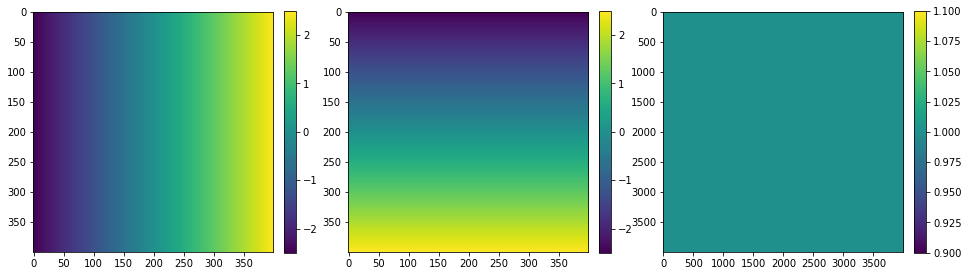

In [37]:
UPSAMPLE = 10

# Save final grid
X, Y = model.X.clone(), model.Y.clone()


model.coerce_XY(*get_meshgrid(
    config.kwargs["defs"]["res"] / UPSAMPLE,
    config.kwargs["defs"]["nx"] * UPSAMPLE,
    config.kwargs["defs"]["ny"] * UPSAMPLE
))
model.mask = torch.full_like(model.X, True, dtype=bool, device="cuda:0")
model.stochastic_specs['sigma_stat'] *= UPSAMPLE

plot_mult([X, Y, model.mask], 1, True)

In [40]:
# parm_dict_upd = {'gamma_1' : 0.0443,
#             'gamma_2' : 0.0069,
#             'x' : -0.0102,
#             'y' : 0.0202,
#             'M' : 1e13,
#             'c_200c' : 20,
#             'tau' : 5}

# PARAMS['truth'] = parm_dict_upd

print("### PARAMS['truth'] ###")
for k in PARAMS['truth']:
    print(k, '\t', PARAMS['truth'][k])
print('\n')


print('### model ###')
for lens in model.alphas.values(): # looping over ext and main
    for spec in lens.stochastic_specs.values(): # looping over lens params
        if isinstance(spec, Sampler):
            print(spec.name, '\t', spec.d)

# plot_mult([model() for _ in range(3)], 1)
# plt.imshow(model(), **imkwargs)
# plt.colorbar()
# plt.show()

### PARAMS['truth'] ###
ext/gamma_1 	 0.007
ext/gamma_2 	 0.01
main/x 	 0.3
main/y 	 0.1
main/phi 	 0.0
main/q 	 1.0
main/index 	 1.0
main/r_e 	 1.0
main/I_e 	 5.0


### model ###
gamma_1 	 Normal(loc: 0.0, scale: 0.05000000074505806)
gamma_2 	 Normal(loc: 0.0, scale: 0.05000000074505806)
x 	 Uniform(low: -1.0, high: 1.0)
y 	 Uniform(low: -1.0, high: 1.0)


In [42]:
X

tensor([[-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938],
        [-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938],
        [-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938],
        ...,
        [-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938],
        [-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938],
        [-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938]])

In [45]:
sigma_stat

NameError: name 'sigma_stat' is not defined

In [51]:
XY

NameError: name 'XY' is not defined

In [50]:
model

<clipppy.stochastic.StochasticWrapper<LensingModelBase> object at 0x14ebc6514400>

In [54]:
X

tensor([[-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938],
        [-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938],
        [-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938],
        ...,
        [-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938],
        [-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938],
        [-2.4938, -2.4813, -2.4688,  ...,  2.4688,  2.4813,  2.4938]])

In [55]:
model(sigma_stat = NOISE, X = X, Y = Y)

TypeError: __call__() got an unexpected keyword argument 'X'

Ideally there should be **no** original image in the lensing. However, Noemi once read that physically there should *always* be one. (You better forget that last part)

In [12]:
# Sample from the model
with pyro.poutine.trace() as tracer, pyro.condition(data=PARAMS['truth']):
    OBS = model() # ???
OBSTRACE = tracer.trace

# Downsample observation
OBS = torch.tensor(downscale_local_mean(OBS, (UPSAMPLE, UPSAMPLE)))

# Downsample info from trace
data = dict(trace=OBSTRACE, obs=OBS, **{
    key: torch.tensor(downscale_local_mean(OBSTRACE.nodes[key]['value'], (UPSAMPLE, UPSAMPLE)))
    for key in ('mu', 'Xsrc', 'Ysrc')
})

In [40]:
dict(trace=OBSTRACE, obs=OBS, **{
    key: torch.tensor(downscale_local_mean(OBSTRACE.nodes[key]['value'], (UPSAMPLE, UPSAMPLE)))
    for key in ('mu', 'Xsrc', 'Ysrc')
})

{'trace': <pyro.poutine.trace_struct.Trace at 0x14cced7ccd00>,
 'obs': tensor([[-0.3154,  1.1747, -0.6110,  ...,  0.5879,  0.8991, -0.3138],
         [ 0.3496, -0.1995,  1.2953,  ...,  0.6495,  0.1276, -0.4242],
         [ 0.6008,  1.0658,  0.1931,  ..., -0.1584, -0.4295,  0.1357],
         ...,
         [ 0.2202, -0.1178,  0.9244,  ...,  0.4558, -1.0052, -0.7647],
         [ 1.4938, -1.8927,  0.3083,  ..., -0.7515,  0.1128, -0.5244],
         [ 0.5994, -1.5518,  0.2948,  ..., -0.7893,  2.2606,  1.9982]]),
 'mu': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Xsrc': tensor([[-1.5134, -1.5037, -1.4940,  ...,  1.4551,  1.4656,  1.4761],
         [-1.5106, -1.5008, -1.4911,  ...,  1.4526,  1.4631,  1.4737],
         [-1.5077, -1.4980, -1.4882,  ...,  1.4501,  1.4607,  1.4712],

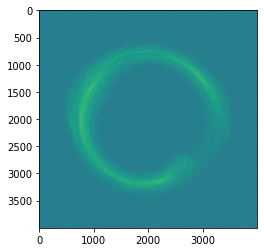

In [39]:
plt.imshow( tracer.trace.nodes['image']['value'] )

In [14]:
keys = OBSTRACE.nodes.keys()
for k in keys: print(k,  OBSTRACE.nodes[k]['value'] )

ext/gamma_1 0.007
ext/gamma_2 0.01
main/phi 1.0
main/q 0.75
main/r_ein 1.5
main/slope 2.1
main/x -0.05
main/y 0.1
Xsrc tensor([[-1.5191, -1.5181, -1.5171,  ...,  1.4799,  1.4809,  1.4820],
        [-1.5188, -1.5178, -1.5168,  ...,  1.4796,  1.4807,  1.4817],
        [-1.5185, -1.5175, -1.5166,  ...,  1.4794,  1.4804,  1.4815],
        ...,
        [-1.4582, -1.4571, -1.4561,  ...,  1.4488,  1.4498,  1.4508],
        [-1.4584, -1.4574, -1.4563,  ...,  1.4491,  1.4501,  1.4511],
        [-1.4587, -1.4576, -1.4566,  ...,  1.4494,  1.4504,  1.4514]])
Ysrc tensor([[-1.5670, -1.5667, -1.5664,  ..., -1.5658, -1.5661, -1.5663],
        [-1.5659, -1.5657, -1.5654,  ..., -1.5648, -1.5650, -1.5652],
        [-1.5649, -1.5646, -1.5643,  ..., -1.5637, -1.5639, -1.5642],
        ...,
        [ 1.5756,  1.5753,  1.5751,  ...,  1.6289,  1.6292,  1.6295],
        [ 1.5767,  1.5764,  1.5761,  ...,  1.6299,  1.6302,  1.6304],
        [ 1.5777,  1.5775,  1.5772,  ...,  1.6309,  1.6311,  1.6314]])
mu tenso

Observation with lens parameters that are random drawn from distributions

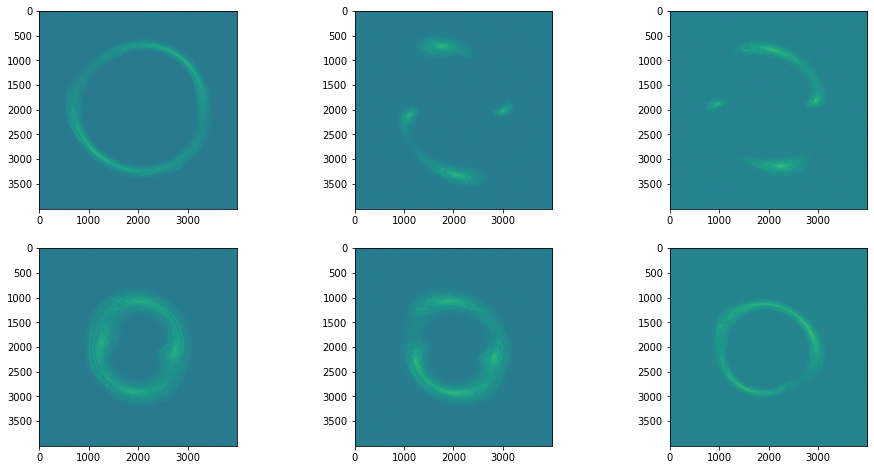

In [15]:
plot_mult([model() for _ in range(6)], 2)

`OBS` = `data['obs']` observation with noise

`data['mu']` observation without noise

`Xsrc` & `Ysrc` displacement fields / deflection fields, see `SPLELens/Lensbase/_deflection`

source + `Xsrc` = observation, see `pyrofit/mode/raytrace` (line 95): `self.X - alpha is source - Xsrc`

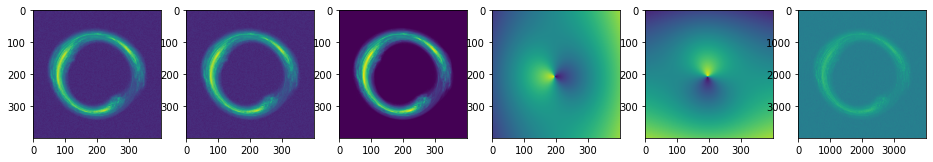

In [16]:
plots = [OBS, data['obs'], data['mu'], data['Xsrc'], data['Ysrc'], OBSTRACE.nodes['image']['value']]
plot_mult(plots, 1)

In [17]:
# Restore coarse grid
model.coerce_XY(X, Y)
model.mask = MASK
model.stochastic_specs['sigma_stat'] /= UPSAMPLE

#### Show mock observation

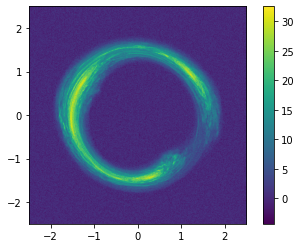

In [18]:
plt.imshow(np.ma.array(data=OBS, mask=False), **imkwargs)
plt.colorbar()

#### Make a mask

41949 unmasked pixels (26.218124389648438% of image)
S/N: 2040.4718017578125


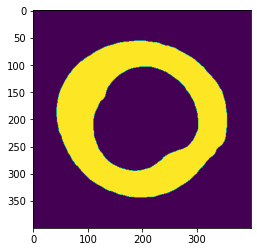

In [19]:
# Generate mask
model.mask = MASK = torch.tensor(get_mask(OBS, sigma=3., th=1.), dtype=bool)
print(f"{MASK.sum()} unmasked pixels ({MASK.sum().float() / MASK.numel() * 100}% of image)")
snr = (MASK * OBS).sum() / (NOISE * np.sqrt(MASK.sum().float()))
print(f"S/N: {snr}")

plt.imshow(MASK)

#### Save everything

In [20]:
torch.save(data, os.path.join(BASEDIR, f"mock_sigma_stat=1.pt"))
np.save(os.path.join(BASEDIR, f"mask.npy"), MASK)

# Plot Lens

In [21]:
from pyrofit.lensing.lenses import *

In [22]:
lenses = ['PointMassLens', 'GaussianLens', 'NFWLens', 'TrueTruncatedNFWLens', 'JaffeLens', 'SimonasJaffeLens', 'SPLELens', 'SPLELens2', 'ExternalShear', ]

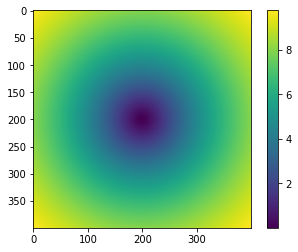

In [23]:
nfw = NFWLens(0.5, 2)
plt.imshow( nfw._m(torch.sqrt( X**2 + Y**2 )) )
plt.colorbar()

# Adding lens light

In [24]:
from pyrofit.lensing.sources import SersicSource

In [25]:
sersic = SersicSource()

In [54]:
lens =  sersic(X,Y, x = 0.3, y = 0.1, phi = 0., q = 1., index = 1., r_e = 1., I_e = 5.)

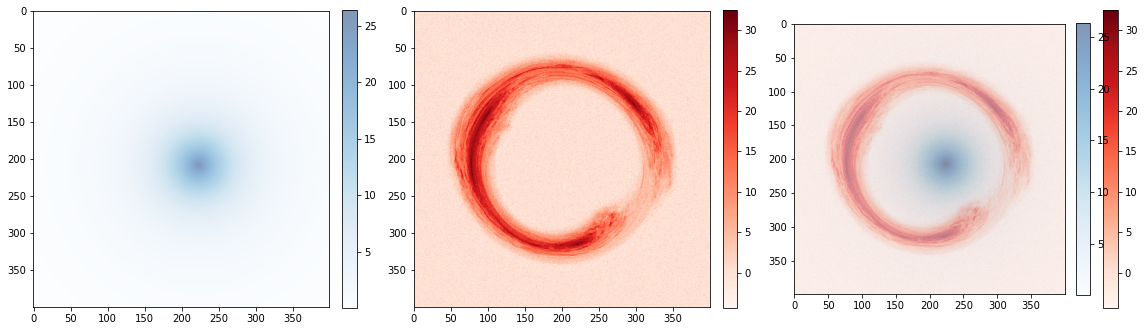

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 8))

for ax in [ax2, ax3]:
    im = ax.imshow(OBS, cmap = 'Reds')
    fig.colorbar(im, fraction=0.046, pad=0.04, ax = ax)

for ax in [ax1, ax3]:
    im = ax.imshow(lens, alpha = 0.5, cmap = 'Blues')
    fig.colorbar(im, fraction=0.046, pad=0.04, ax = ax)

plt.tight_layout()
plt.show()

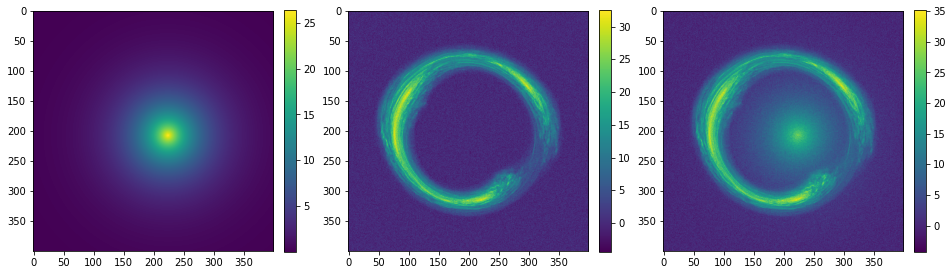

In [56]:
plot_mult([lens, OBS, OBS + lens], colorbar = True)

#### Creating Mask and savring everything

84181 unmasked pixels (52.613121032714844% of image)
S/N: 1447.680908203125


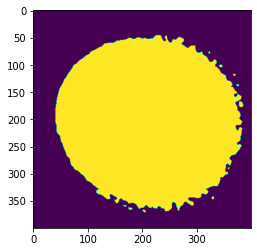

In [57]:
# Generate mask
model.mask = MASK = torch.tensor(get_mask(OBS + lens, sigma=3., th=1.), dtype=bool)
print(f"{MASK.sum()} unmasked pixels ({MASK.sum().float() / MASK.numel() * 100}% of image)")
snr = (MASK * OBS).sum() / (NOISE * np.sqrt(MASK.sum().float()))
print(f"S/N: {snr}")

plt.imshow(MASK)

In [58]:
torch.save(OBS, os.path.join(BASEDIR, 'OBS.pt'))
torch.save(lens, os.path.join(BASEDIR, 'lens.pt'))

In [59]:
torch.save(data, os.path.join(BASEDIR, f"mock_sigma_stat=1.pt"))
np.save(os.path.join(BASEDIR, f"mask.npy"), MASK)